In [174]:
import random
import simpy
import functools
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# Demo 3: First few blocks copied and modified from demo 2.

In [152]:
class PatientGenerator(object):
    '''
    Generates patients.
    '''
    def __init__(self, env, hospital, arr_interval_func, prep_time_func, op_time_func, rec_time_func):
        self.env = env
        self.arr_interval_func = arr_interval_func
        self.patient_id = 0
        self.hospital = hospital
        self.prep_time_func = prep_time_func
        self.op_time_func = op_time_func
        self.rec_time_func = rec_time_func
        self.action = env.process(self.run())
        
    def run(self):
        while True:
            # print('before')
            time = np.round(self.arr_interval_func(), 1)
            # print(time)
            yield self.env.timeout(time)
            # print('after')
            self.patient_id += 1
            self.hospital.patients_generated += 1
            # print(f'Patient number {self.patient_id} arrived at time {self.env.now}')
            # print(self.hospital.situation())
            patient = Patient(self.patient_id, 
                              self.env.now,
                              self.prep_time_func,
                              self.op_time_func,
                              self.rec_time_func)
            self.hospital.put(patient, 0)

In [50]:
class Patient(object):
    '''
    Patient keeps track of arrival times to different places and idle times.
    '''
    def __init__(self, patient_id, arrival_time, prep_time_func, op_time_func, rec_time_func):
        self.patient_id = patient_id
        self.idle_time = 0
        self.prep_time = np.round(prep_time_func(), 1)
        self.op_time = np.round(op_time_func(), 1)
        self.rec_time = np.round(rec_time_func(), 1)

In [131]:
class Room(object):
    '''
    Room keeps track of its own usage and throughput.
    '''
    def __init__(self, hospital, env, capacity, name, index):
        # print('room init')
        self.hospital = hospital
        self.env = env
        self.capacity = capacity
        self.patients_taken = 0
        self.patients_processed = 0
        self.active_time = 0
        # self.out = hospital.rooms[index + 1]
        # self.unit = simpy.Resource(env, capacity)
        self.id = index
        self.name = name
        self.people_in = 0
    def available_places(self):
        return self.people_in < self.capacity
    def put(self, patient):
        got_in = False
        time_start = self.env.now
        if self.name == 'preparation':
            self.hospital.queue += 1
        self.hospital.update_situation()
        while not got_in:
            # print(self.available_places() and hospital.rooms_free(self.name))
            if self.available_places(): # and hospital.rooms_free(self.name):
                # self.hospital.idle_time += self.env.now - time_start
                self.hospital.update_situation()
                if self.name == 'preparation':
                    self.hospital.queue += -1
                # print(f'Patient {patient.patient_id} got in to {self.name} at time {self.env.now}')
                self.people_in += 1
                self.patients_taken += 1
                # self.hospital.update_situation()
                # print(self.hospital.situation())
                # print('got in')
                got_in = True
                
                if self.name == 'preparation':
                    yield_time = patient.prep_time
                    self.hospital.idle_time_before += self.env.now - time_start
                elif self.name == 'operation':
                    yield_time = patient.op_time
                    self.hospital.idle_time_after_prep += self.env.now - time_start
                else: 
                    yield_time = patient.rec_time
                    self.hospital.idle_time_after_op += self.env.now - time_start
                self.hospital.set_previous_free(self.id - 1)
                # self.patients_taken += 1
                yield self.env.timeout(yield_time)
                self.hospital.update_situation()
                self.active_time += yield_time
                # patient.departure_times[self.name] = self.env.now
                # self.hospital.update_situation()
                self.hospital.put(patient, self.id + 1)
                self.patients_processed += 1
            else:
                self.hospital.update_situation()
                yield self.env.timeout(0.01)
                self.hospital.update_situation()

In [134]:
class Hospital(object):
    '''
    Hospital with three rooms. Keeps track on availability of rooms
    '''
    def __init__(self, env, prep_capacity, op_capacity, rec_capacity):
        self.env = env
        self.prep = Room(self, env, prep_capacity, 'preparation', 0)
        self.op = Room(self, env, op_capacity, 'operation', 1)
        self.rec = Room(self, env, rec_capacity, 'recovery', 2)
        # self.stats = Stats(self, env, 'stats', 3)
        self.patients_generated = 0
        self.patients_through = 0
        self.idle_time_before = 0
        self.idle_time_after_prep = 0
        self.idle_time_after_op = 0
        self.rooms = [self.prep, self.op, self.rec]
        self.queue = 0
        self.queues = [0]
        self.preparations = [self.prep.people_in]
        self.operations = [self.op.people_in]
        self.recoverys = [self.rec.people_in]
        self.timestamps = [self.env.now]
        self.operation_blocked = False
        self.operation_blockeds = [False]
    def rooms_free(self, name):
        if name == 'preparation':
            return self.op.available_places() #and self.rec.available_places()
        elif name == 'operation':
            return self.rec.available_places()
        return True
    def put(self, patient, room_id):
        # print('hospital')
        # print(self.rooms[room_id].put(patient))
        if room_id <=2:
            self.env.process(self.rooms[room_id].put(patient))
        else:
            self.set_previous_free(room_id - 1)
            self.patients_through += 1
    def set_previous_free(self, i):
        if i >= 0:
            self.rooms[i].people_in -= 1
            
    def update_situation(self):
        if self.queues[-1] == self.queue and \
        self.preparations[-1] == self.prep.people_in and \
        self.operations[-1] == self.op.people_in and \
        self.recoverys[-1] == self.rec.people_in: 
            return
        self.timestamps.append(self.env.now)
        self.queues.append(self.queue)
        self.preparations.append(self.prep.people_in)
        self.operations.append(self.op.people_in)
        self.recoverys.append(self.rec.people_in)
        if self.rec.available_places():
            self.operation_blocked = False
        else:
            self.operation_blocked = True
        # print(self.operation_blocked)
        self.operation_blockeds.append(self.operation_blocked)
        
    def situation(self):
        return(f' Preparation: {self.prep.people_in}/{self.prep.capacity}, people through: {self.prep.patients_processed},\n' 
               f' Operation: {self.op.people_in}/{self.op.capacity}, people through: {self.op.patients_processed},\n')
    
    def get_stats(self):
        blocked_time = 0
        for i, boolean in enumerate(self.operation_blockeds):
            if boolean:
                try:
                    blocked_time += self.timestamps[i + 1] - self.timestamps[i]
                except IndexError:
                    blocked_time += self.env.now - self.timestamps[i]
        time_sum_queues = self.timestamps[0]
        for i, num in enumerate(self.queues):
            try:
                time = self.timestamps[i + 1] - self.timestamps[i]
            except IndexError:
                time = self.env.now - self.timestamps[i]
            time_sum_queues += time * num
        average_queue = time_sum_queues / self.env.now
        
        blocked_rate = blocked_time/self.env.now
        preparation_use_rate = self.prep.active_time / (self.prep.capacity * self.env.now)
        operation_use_rate = self.op.active_time / (self.op.capacity * self.env.now)
        recovery_use_rate = self.rec.active_time / (self.rec.capacity * self.env.now)
        return {'patients created':self.patients_generated, 
                'patients through':self.patients_through, 
                'average preparation waiting time': self.idle_time_before/self.prep.patients_taken,
                'average operation waiting time': self.idle_time_after_prep/self.op.patients_taken,
                'average recovery waiting time': self.idle_time_after_op/self.rec.patients_taken,
                'timestamps':self.timestamps,
                'blocked': self.operation_blockeds,
                'people in operation': self.operations,
                'people in preparation': self.preparations,
                'people in recovery': self.recoverys,
                'people in queue': self.queues,
                'preparation_use_rate':preparation_use_rate,
                'operation_use_rate':operation_use_rate,
                'recovery_use_rate':recovery_use_rate,
                'prep_max': self.prep.capacity,
                'op_max': self.op.capacity,
                'rec_max': self.rec.capacity,
                'blocked time': blocked_time,
                'blocked rate': blocked_rate,
                'average queue length': average_queue}

# Excercise 1 and 2
first I run the different combinations, then I plot and print some statistics, and then I'll write something about them.

In [295]:
def run_hospital(*, prep_rooms, op_rooms, rec_rooms, arr_interval, avg_prep_time, avg_rec_time, avg_op_time, max_time, seed=None):
    if seed:
        random.seed(seed)
    env = simpy.Environment()
    hospital = Hospital(env, prep_rooms, op_room, rec_rooms)
    arr_interval_f = functools.partial(random.expovariate, 1./arr_interval)
    prep_time_f = functools.partial(random.expovariate, 1./avg_prep_time)
    op_time_f = functools.partial(random.expovariate, 1./avg_op_time)
    rec_time_f = functools.partial(random.expovariate, 1./avg_rec_time)
    patient_gen = PatientGenerator(env, hospital, arr_interval_f, prep_time_f, op_time_f, rec_time_f)
    env.run(until=max_time)
    # print(f'{patient_gen.patient_id} patients created')
    # print(hospital.rec.patients_taken)
    stats = hospital.get_stats()
    # print(stats['blocked'])
    # print(env.now)
    return stats

stats_3_4 = []
first_seed = 42
for i in range(20):
    stats_3_4.append(run_hospital(arr_interval=25, 
                              avg_prep_time=40, 
                              avg_rec_time=40,
                              avg_op_time=20,
                              max_time=1000, 
                              op_rooms=1, 
                              prep_rooms=3, 
                              rec_rooms=4)) 
#                               seed=first_seed+i))
    

In [296]:
stats_3_5 = []
first_seed = 42
for i in range(20):
    stats_3_5.append(run_hospital(arr_interval=25, 
                              avg_prep_time=40, 
                              avg_rec_time=40,
                              avg_op_time=20,
                              max_time=1000, 
                              op_rooms=1, 
                              prep_rooms=3, 
                              rec_rooms=5)) 
                              #seed=first_seed+i))
    

In [297]:
stats_4_5 = []
first_seed = 42
for i in range(20):
    stats_4_5.append(run_hospital(arr_interval=25, 
                              avg_prep_time=40, 
                              avg_rec_time=40,
                              avg_op_time=20,
                              max_time=1000, 
                              op_rooms=1, 
                              prep_rooms=4, 
                              rec_rooms=5)) 
                              #seed=first_seed+i))
    

In [298]:
blocked_3_4 = [i['blocked rate'] for i in stats_3_4]
blocked_3_5 = [i['blocked rate'] for i in stats_3_5]
blocked_4_5 = [i['blocked rate'] for i in stats_4_5]

In [299]:
def calculate_and_draw(array):
    bins = np.linspace(np.min(array), np.max(array), 7)
    histogram, bins = np.histogram(array, bins=bins, density=True)

    bin_centers = 0.5*(bins[1:] + bins[:-1])

    # Compute the PDF on the bin centers from scipy distribution object
    pdf = scipy.stats.norm.pdf(bin_centers)
    # plt.figure(figsize=(15, 7.5))
    plt.plot(bin_centers, histogram)
    #plt.plot(bin_centers, pdf, label="PDF")
    mean = np.average(array)
    print(f"Mean: {mean}")
    std = np.std(array)
    print(f"Standard deviation: {std}")
    var = std ** 2
    print(f"Variance: {var}")

    x = np.linspace(mean - 4*std, mean + 4*std, 100)
    plt.plot(x, scipy.stats.norm.pdf(x, mean, mean))
    #plt.title(f"Difference")
    plt.legend()
    ci_norm = scipy.stats.norm.interval(0.95, loc=mean, scale=std)
    ci = [0,0]
    ci[0] = mean - 1.96 * np.sqrt(mean/len(array))
    ci[1] = mean + 1.96 * np.sqrt(mean/len(array))
    print(f"Poisson 95% confidence interval: {ci}")
    print(f"Normal distribution 95% confidence interval: {ci_norm}")

    # cnfidence interval left line
    one_x12, one_y12 = [ci_norm[0],ci_norm[0]], [0, np.max(histogram)/3]
    # cnfidence interval right line
    two_x12, two_y12 = [ci_norm[1],ci_norm[1]], [0, np.max(histogram)/3]

    plt.plot(one_x12, one_y12, two_x12, two_y12, marker = 'o')
    plt.show()

No handles with labels found to put in legend.


Mean: 0.029375500000083828
Standard deviation: 0.022019753285444643
Variance: 0.00048486953475185014
Poisson 95% confidence interval: [-0.045740716890918486, 0.10449171689108613]
Normal distribution 95% confidence interval: (-0.013782423387845202, 0.07253342338801286)


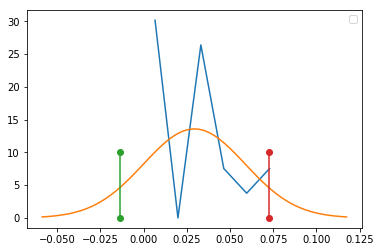

In [300]:
calculate_and_draw(blocked_3_4)

Mean: 0.012098500000005062
Standard deviation: 0.020599095192504812
Variance: 0.00042432272274987485


No handles with labels found to put in legend.


Poisson 95% confidence interval: [-0.03610813730235168, 0.060305137302361804]
Normal distribution 95% confidence interval: (-0.028274984691416538, 0.052471984691426665)


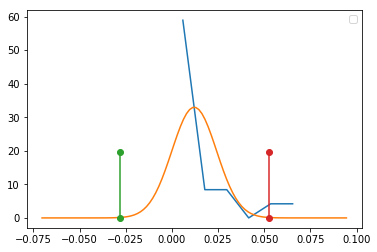

In [301]:
calculate_and_draw(blocked_3_5)

No handles with labels found to put in legend.


Mean: 0.010760500000017905
Standard deviation: 0.013826424149089172
Variance: 0.00019117000475051622
Poisson 95% confidence interval: [-0.03470241719634598, 0.0562234171963818]
Normal distribution 95% confidence interval: (-0.016338793367171735, 0.037859793367207545)


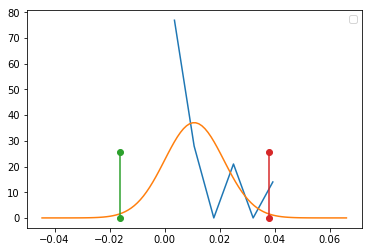

In [302]:
calculate_and_draw(blocked_4_5)

In [303]:
av_que_3_4 = [i['average queue length'] for i in stats_3_4]
av_que_3_5 = [i['average queue length'] for i in stats_3_5]
av_que_4_5 = [i['average queue length'] for i in stats_4_5]

In [308]:
av_que_3_4

[3.739479999996659,
 0.9211199999983574,
 0.3597099999996162,
 0.9126099999993565,
 0.4305299999996844,
 1.789349999998564,
 0.6261099999995376,
 1.2714399999984267,
 2.548349999998257,
 0.38273999999925296,
 2.1801999999984703,
 0.8180599999996025,
 1.728829999998461,
 0.46917999999935617,
 1.390969999998798,
 2.0131399999990314,
 1.1838499999989054,
 1.3476099999988556,
 2.317309999998506,
 1.4760899999974513]

No handles with labels found to put in legend.


Mean: 1.3953339999987575
Standard deviation: 0.8448932013355245
Variance: 0.7138445216629911
Poisson 95% confidence interval: [0.8776316195524616, 1.9130363804450534]
Normal distribution 95% confidence interval: (-0.26062624540161927, 3.0512942453991343)


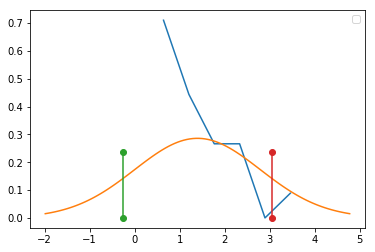

In [304]:
calculate_and_draw(av_que_3_4)

No handles with labels found to put in legend.


Mean: 1.6258729999989119
Standard deviation: 1.8370917787981431
Variance: 3.3749062037277255
Poisson 95% confidence interval: [1.0670369902073173, 2.1847090097905064]
Normal distribution 95% confidence interval: (-1.974760722740072, 5.226506722737896)


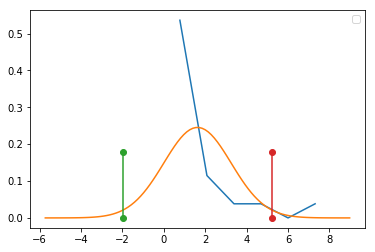

In [305]:
calculate_and_draw(av_que_3_5)

Mean: 0.9387409999991357
Standard deviation: 1.2341969965072621
Variance: 1.5232422261875467


No handles with labels found to put in legend.


Poisson 95% confidence interval: [0.5141077802908398, 1.3633742197074317]
Normal distribution 95% confidence interval: (-1.480240662982605, 3.3577226629808763)


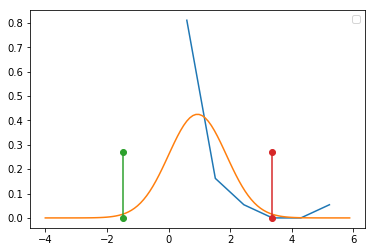

In [306]:
calculate_and_draw(av_que_4_5)

It seem's like it's not a good idea to assume these follow normal distribution. 

It seem's queues are shortest when there's more room in preparation room.

The probability of operation being in blocked state seems really low, but if it's cost effective to have extra room in the recovery room, then it's a good idea.

# Excercise 3
First run, then plot, then talk.

In [310]:
stats_3_4 = []
first_seed = 42
for i in range(20):
    stats_3_4.append(run_hospital(arr_interval=25, 
                              avg_prep_time=40, 
                              avg_rec_time=40,
                              avg_op_time=20,
                              max_time=1000, 
                              op_rooms=1, 
                              prep_rooms=3, 
                              rec_rooms=4,
                              seed=first_seed+i))

In [311]:
stats_3_5 = []
first_seed = 42
for i in range(20):
    stats_3_5.append(run_hospital(arr_interval=25, 
                              avg_prep_time=40, 
                              avg_rec_time=40,
                              avg_op_time=20,
                              max_time=1000, 
                              op_rooms=1, 
                              prep_rooms=3, 
                              rec_rooms=5,
                              seed=first_seed+i))

In [321]:
stats_4_5 = []
first_seed = 42
for i in range(20):
    stats_4_5.append(run_hospital(arr_interval=25, 
                              avg_prep_time=40, 
                              avg_rec_time=40,
                              avg_op_time=20,
                              max_time=1000, 
                              op_rooms=1, 
                              prep_rooms=4, 
                              rec_rooms=5,
                              seed=first_seed+i))

In [322]:
blocked_3_4 = [i['blocked rate'] for i in stats_3_4]
blocked_3_5 = [i['blocked rate'] for i in stats_3_5]
blocked_4_5 = [i['blocked rate'] for i in stats_4_5]

In [323]:
av_que_3_4 = [i['average queue length'] for i in stats_3_4]
av_que_3_5 = [i['average queue length'] for i in stats_3_5]
av_que_4_5 = [i['average queue length'] for i in stats_4_5]

No handles with labels found to put in legend.


Mean: 0.055399500000001864
Standard deviation: 0.03945460663534681
Variance: 0.0015566659847499529
Poisson 95% confidence interval: [-0.0477563818487825, 0.15855538184878623]
Normal distribution 95% confidence interval: (-0.021930108029472928, 0.13272910802947666)


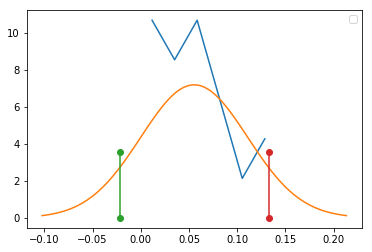

In [324]:
calculate_and_draw(blocked_3_4)

No handles with labels found to put in legend.


Mean: 0.012024500000009826
Standard deviation: 0.017415355429924978
Variance: 0.00030329460475061744
Poisson 95% confidence interval: [-0.036034484175707905, 0.06008348417572756]
Normal distribution 95% confidence interval: (-0.0221089694206072, 0.04615796942062685)


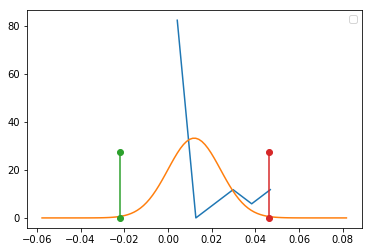

In [325]:
calculate_and_draw(blocked_3_5)

No handles with labels found to put in legend.


Mean: 0.010382499999989536
Standard deviation: 0.014666551358435845
Variance: 0.00021510772874963635
Poisson 95% confidence interval: [-0.0342747569690406, 0.055039756969019665]
Normal distribution 95% confidence interval: (-0.018363412439951727, 0.0391284124399308)


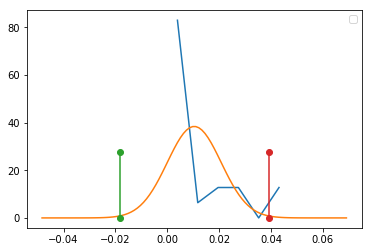

In [326]:
calculate_and_draw(blocked_4_5)

Mean: 1.6567069999987942
Standard deviation: 1.501063042379888
Variance: 2.253190257198766


No handles with labels found to put in legend.


Poisson 95% confidence interval: [1.0925968329571352, 2.2208171670404533]
Normal distribution 95% confidence interval: (-1.2853225015899072, 4.598736501587496)


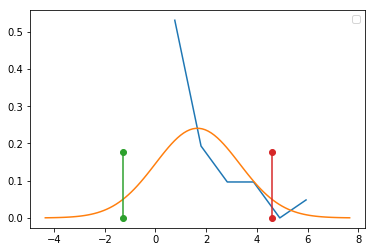

In [327]:
calculate_and_draw(av_que_3_4)

No handles with labels found to put in legend.


Mean: 1.6458634999988047
Standard deviation: 1.493001079457263
Variance: 2.2290522232605525
Poisson 95% confidence interval: [1.0836024742467343, 2.208124525750875]
Normal distribution 95% confidence interval: (-1.2803648446168545, 4.572091844614464)


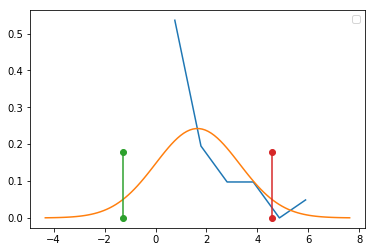

In [328]:
calculate_and_draw(av_que_3_5)

No handles with labels found to put in legend.


Mean: 1.0564124999990931
Standard deviation: 1.1819414588875896
Variance: 1.3969856122373236
Poisson 95% confidence interval: [0.6059508334836994, 1.506874166514487]
Normal distribution 95% confidence interval: (-1.2601501912553115, 3.3729751912534978)


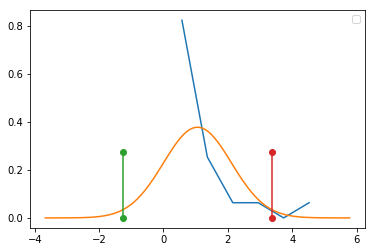

In [329]:
calculate_and_draw(av_que_4_5)

The patterns are more clear. The probability of blockedness is dependent on the recovery room space, and the average length of the queue is dependent on the size of the preparation room.

# Excercise 4:
in these excercises I have assumed blockedness of the operation to mean that recovery room is full. It is a sort of passive block until a patient tries to come out of surgery, when the block is realised. The confidence interval is smallest with 4p, 5r configuration. The intervals are visible with `calculate_and_draw(blocked_x_y)` plots.